In [2]:
# data processing tools
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from math import sqrt
import itertools
from collections import Counter


In [3]:

# model tools
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from scipy.stats import norm
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.svm import SVR
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import neighbors
import xgboost as xgb


In [4]:
# NLP tools
# import spacy
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [5]:
# Visualization tools
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [10]:
# load and look at our austin housing data
df = pd.read_csv('kaggleRealEstateData.csv')
df.head()

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,latestPrice,numPriceChanges,latest_saledate,latest_salemonth,latest_saleyear,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
0,111373431,pflugerville,14424 Lake Victor Dr,78660,"14424 Lake Victor Dr, Pflugerville, TX 78660 i...",30.430632,-97.663078,1.98,2,True,True,True,True,False,False,Single Family,2,2012,305000.0,5,2019-09-02,9,2019,"Coldwell Banker United, Realtors - South Austin",39,0,5,2,1,3,0,1,0,6011.0,2601.0,1,0,1,1,1.266667,2.666667,1063,14,3.0,4,2,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f...
1,120900430,pflugerville,1104 Strickling Dr,78660,Absolutely GORGEOUS 4 Bedroom home with 2 full...,30.432673,-97.661697,1.98,2,True,True,True,True,False,False,Single Family,2,2013,295000.0,1,2020-10-13,10,2020,Agent Provided,29,0,1,2,0,0,0,0,0,6185.0,1768.0,1,0,1,1,1.400000,2.666667,1063,14,2.0,4,1,120900430_8255c127be8dcf0a1a18b7563d987088-p_f...
2,2084491383,pflugerville,1408 Fort Dessau Rd,78660,Under construction - estimated completion in A...,30.409748,-97.639771,1.98,0,True,True,False,True,False,False,Single Family,0,2018,256125.0,1,2019-07-31,7,2019,Agent Provided,2,0,4,1,0,1,0,0,0,7840.0,1478.0,0,2,1,1,1.200000,3.000000,1108,14,2.0,3,1,2084491383_a2ad649e1a7a098111dcea084a11c855-p_...
3,120901374,pflugerville,1025 Strickling Dr,78660,Absolutely darling one story home in charming ...,30.432112,-97.661659,1.98,2,True,True,True,True,False,False,Single Family,2,2013,240000.0,4,2018-08-08,8,2018,Agent Provided,9,0,0,2,0,0,0,0,0,6098.0,1678.0,1,0,1,1,1.400000,2.666667,1063,14,2.0,3,1,120901374_b469367a619da85b1f5ceb69b675d88e-p_f...
4,60134862,pflugerville,15005 Donna Jane Loop,78660,Brimming with appeal & warm livability! Sleek ...,30.437368,-97.656860,1.98,0,True,True,False,True,False,False,Single Family,0,2002,239900.0,3,2018-10-31,10,2018,Agent Provided,27,0,0,1,0,0,0,0,0,6708.0,2132.0,1,0,1,1,1.133333,4.000000,1223,14,3.0,3,2,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f.jpg


In [11]:
df.dtypes

zpid                            int64
city                           object
streetAddress                  object
zipcode                         int64
description                    object
latitude                      float64
longitude                     float64
propertyTaxRate               float64
garageSpaces                    int64
hasAssociation                   bool
hasCooling                       bool
hasGarage                        bool
hasHeating                       bool
hasSpa                           bool
hasView                          bool
homeType                       object
parkingSpaces                   int64
yearBuilt                       int64
latestPrice                   float64
numPriceChanges                 int64
latest_saledate                object
latest_salemonth                int64
latest_saleyear                 int64
latestPriceSource              object
numOfPhotos                     int64
numOfAccessibilityFeatures      int64
numOfApplian

In [12]:
df.shape

(15171, 47)

In [13]:
df.rename(columns={'latestPrice':'price'}, inplace=True)

In [14]:
df['latest_saleyear'].unique()

array([2019, 2020, 2018, 2021])

In [15]:
df['latest_saledate'].min()

'2018-01-22'

In [16]:
df['latest_saledate'].max()

'2021-01-30'

In [17]:
jan2018_to_2019 = .024/12
jan2019_to_2020 = .037/12
jan2020_to_2021 = .193/12

# create reverse time series number for month
for i in range(1,13):
    df['time_series'] = df['latest_salemonth'].apply(lambda x: abs(x-13))

# adjust 2018 to 2019
df.loc[df['latest_saleyear']==2018, 'adj_price'] = df.loc[df['latest_saleyear']==2018].apply(lambda x: int( (x['price'])*(1+(jan2018_to_2019*x['time_series']))*(1+(jan2019_to_2020*x['time_series']))*(1+(jan2020_to_2021*x['time_series'])) ) , axis=1 )

# adjust 2019 to 2020                                                            
df.loc[df['latest_saleyear']==2019, 'adj_price'] = df.loc[df['latest_saleyear']==2019].apply(lambda x: int( (x['price'])*(1+(jan2019_to_2020*x['time_series']))*(1+(jan2020_to_2021*x['time_series'])) ) , axis=1)
                                                                                  
# adjust 2020 to 2021
df.loc[df['latest_saleyear']==2020, 'adj_price'] = df.loc[df['latest_saleyear']==2020].apply(lambda x: int( (x['price'])*(1+(jan2020_to_2021*x['time_series'])) ), axis=1)

#copy 2021 to self
df.loc[df['latest_saleyear']==2021, 'adj_price'] = df.loc[df['latest_saleyear']==2021].apply(lambda x: int(x['price']), axis=1)

# rename original price column and make adj_price our price column
df.rename(columns={'price' : 'orig_price', 'adj_price' : 'price'}, inplace=True)

# put price at the front of the data frame
df.set_index('price', inplace=True)
df.reset_index(inplace=True)

In [18]:
df['homeType'].value_counts(normalize=True)

Single Family            0.938699
Condo                    0.030980
Townhouse                0.011469
Multiple Occupancy       0.006328
Vacant Land              0.005471
Residential              0.002439
Apartment                0.002439
Mobile / Manufactured    0.001121
MultiFamily              0.000659
Other                    0.000395
Name: homeType, dtype: float64

In [19]:
df = df.loc[((df['homeType'] == 'Single Family') | (df['homeType'] == 'Condo')) | (df['homeType'] == 'Townhouse')]

In [20]:
df[df.duplicated(subset=['latitude','longitude'], keep=False)].sort_values('latitude')

,price,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,orig_price,numPriceChanges,latest_saledate,latest_salemonth,latest_saleyear,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage,time_series


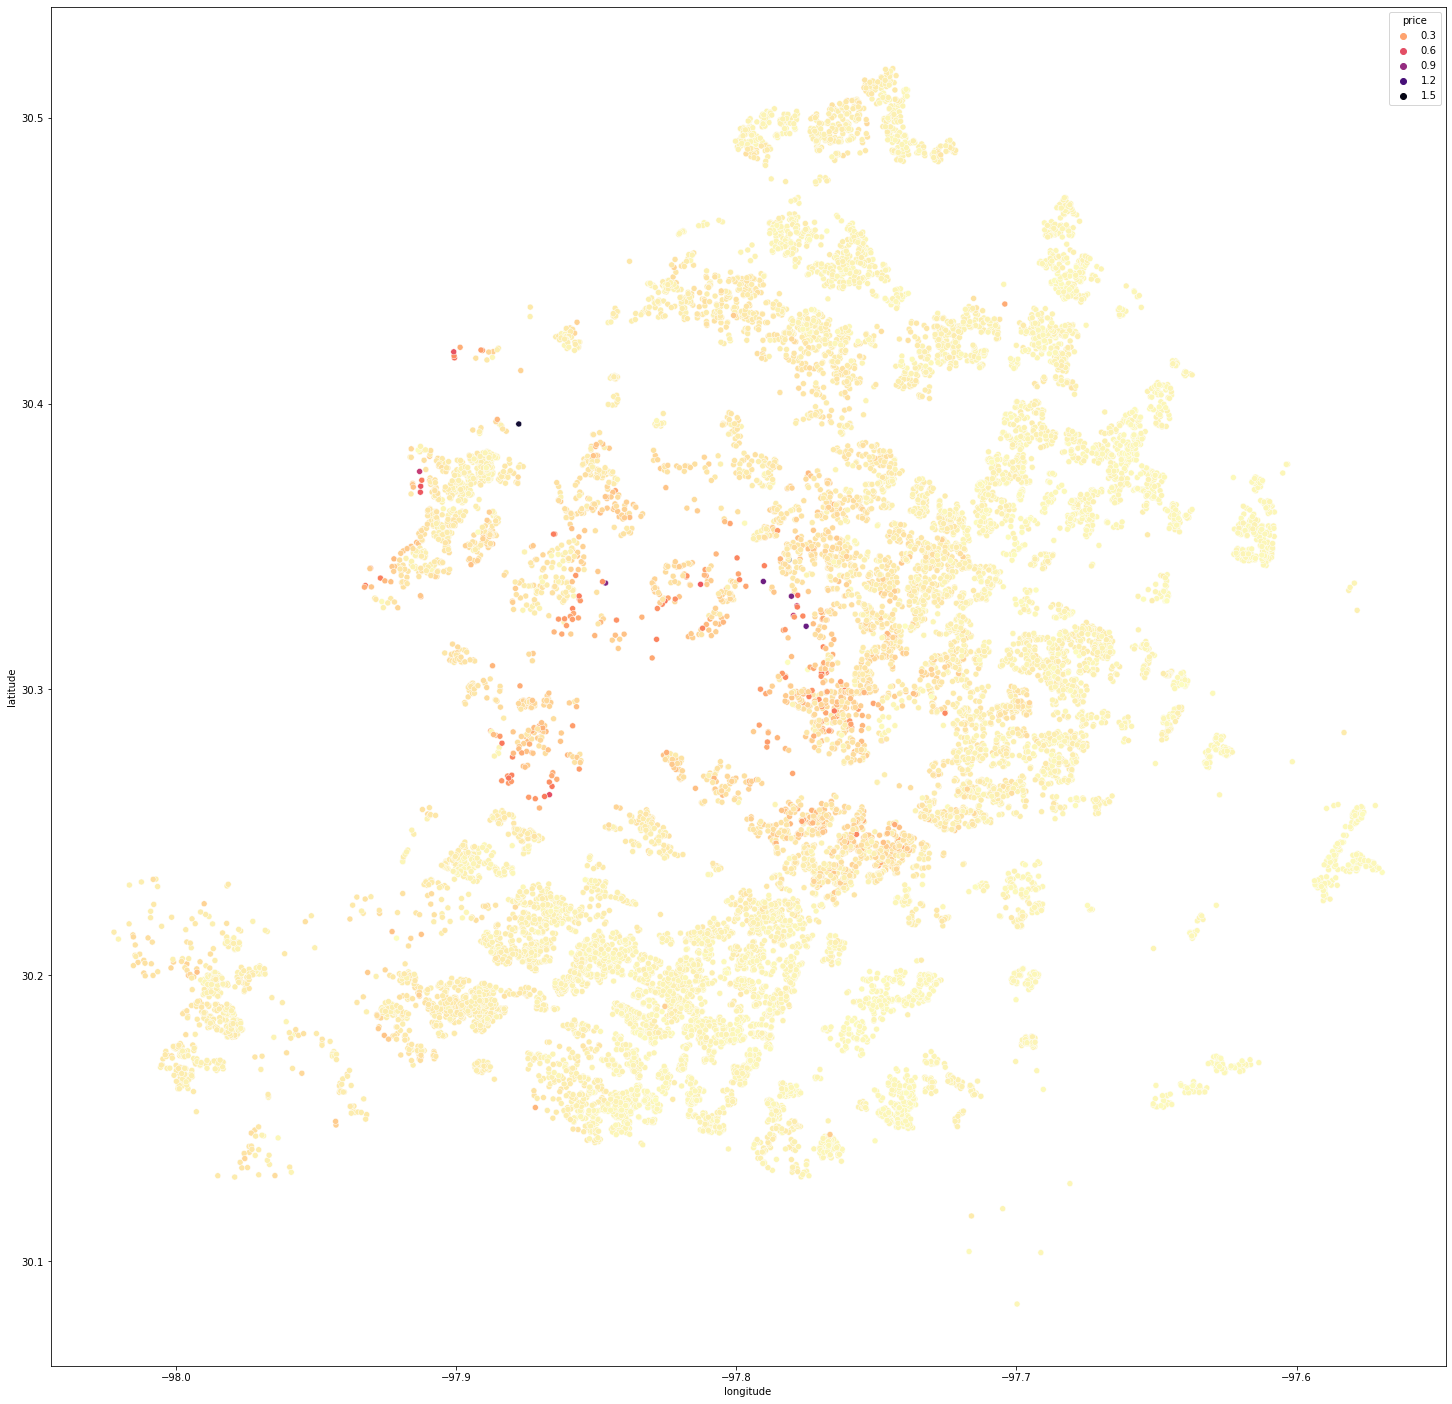

In [21]:
# plotting latitude and longitude as a visual scatter plot to look for location-based outliers

plt.figure(figsize=(25,25))

sns.scatterplot(data=df, x="longitude", y="latitude", hue="price", palette="magma_r");

In [22]:
# drop latitidue below 30.12 to remove the few outliers in the SE
df.drop(df[df['latitude']<30.12].index , inplace=True)

In [23]:
# looking for outliers in the percentiles
df.describe()

,price,zpid,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,parkingSpaces,yearBuilt,orig_price,numPriceChanges,latest_salemonth,latest_saleyear,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,time_series
count,1.488000e+04,1.488000e+04,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,1.488000e+04,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,1.488000e+04,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000
mean,5.710926e+05,1.043332e+08,78736.001075,30.291923,-97.778870,1.994194,1.228159,1.227554,1988.720228,5.119011e+05,3.032997,6.722043,2019.077151,30.830645,0.013239,3.490927,1.710081,0.667608,0.472446,0.002621,0.210753,0.011761,1.207274e+05,2205.497177,0.941062,0.048790,1.034946,0.977621,1.838871,5.792622,1240.125134,14.868952,2.696704,3.441599,1.469422,6.277957
std,4.933980e+05,3.171262e+08,18.879984,0.097245,0.084904,0.053290,1.342097,1.342224,21.504783,4.413982e+05,2.481883,3.137916,0.813532,21.187673,0.181175,1.868605,0.778832,0.983225,0.828483,0.059625,0.490729,0.113874,1.237193e+07,1368.133002,0.235802,0.234267,0.260259,0.292564,1.065639,1.859791,325.654819,1.743026,1.025875,0.811953,0.523915,3.137916
min,6.094000e+03,2.858495e+07,78617.000000,30.127161,-98.022057,1.980000,0.000000,0.000000,1905.000000,5.500000e+03,1.000000,1.000000,2018.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+02,300.000000,0.000000,0.000000,0.000000,0.000000,0.200000,2.333333,396.000000,10.000000,0.000000,0.000000,1.000000,1.000000
25%,3.445055e+05,2.941134e+07,78727.000000,30.202993,-97.838747,1.980000,0.000000,0.000000,1975.000000,3.090000e+05,1.000000,4.000000,2018.000000,20.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.534000e+03,1485.000000,1.000000,0.000000,1.000000,1.000000,1.100000,4.000000,983.000000,14.000000,2.000000,3.000000,1.000000,4.000000
50%,4.538920e+05,2.949518e+07,78739.000000,30.285250,-97.769810,1.980000,1.000000,1.000000,1993.000000,4.050000e+05,2.000000,7.000000,2019.000000,29.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.232000e+03,1976.000000,1.000000,0.000000,1.000000,1.000000,1.566667,6.000000,1298.000000,15.000000,3.000000,3.000000,1.000000,6.000000
75%,6.370388e+05,7.033871e+07,78749.000000,30.367340,-97.718283,1.980000,2.000000,2.000000,2006.000000,5.750000e+05,4.000000,9.000000,2020.000000,39.000000,0.000000,4.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.089000e+04,2687.000000,1.000000,0.000000,1.000000,1.000000,2.266667,7.000000,1498.500000,16.000000,3.000000,4.000000,2.000000,9.000000
max,1.555613e+07,2.146313e+09,78759.000000,30.517174,-97.569504,2.210000,22.000000,22.000000,2020.000000,1.350000e+07,23.000000,12.000000,2021.000000,179.000000,8.000000,10.000000,6.000000,8.000000,6.000000,2.000000,4.000000,3.000000,1.508483e+09,109292.000000,2.000000,2.000000,3.000000,2.000000,9.000000,9.500000,1913.000000,19.000000,27.000000,20.000000,4.000000,12.000000


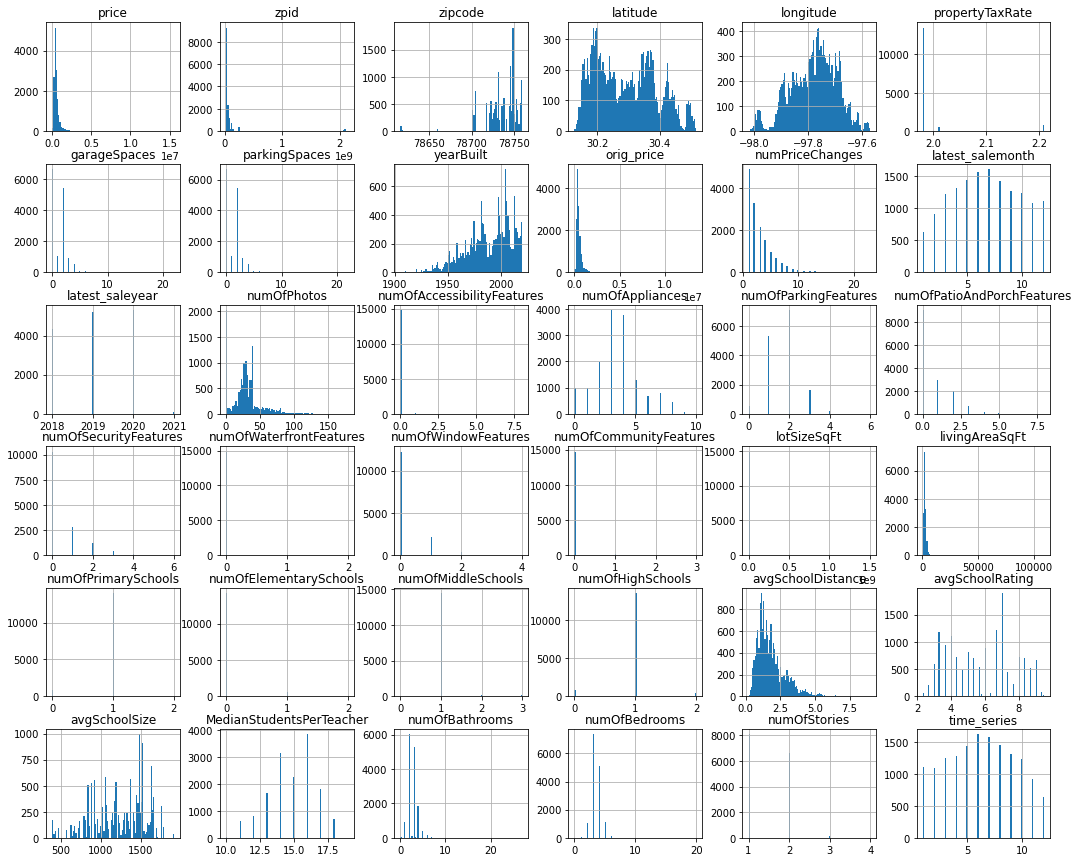

In [24]:
# check how our histograms are looking
df.hist(figsize=(18,15), bins=100);

In [26]:
#check what is going on with the lotSizeSqFt outliers by sorting descending
df.sort_values('lotSizeSqFt', ascending=False).head(5)


,price,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,orig_price,numPriceChanges,latest_saledate,latest_salemonth,latest_saleyear,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage,time_series
14654,1941912.0,58297775,austin,3200 W 35th St,78703,Fabulous 4 Bed 4 Bath house on one of the larg...,30.314316,-97.768044,1.98,5,False,True,True,True,False,False,Single Family,5,1955,1650000.0,3,2020-02-20,2,2020,Broker Provided,23,0,8,2,2,1,0,0,0,1.508483e+09,3328.0,1,0,1,1,1.633333,7.000000,1298,16,4.0,4,2,58297775_ea7a00b4cbb5788f252f04fce1c9e84a-p_f.jpg,11
9244,190324.0,62605548,austin,706 W 22nd St APT 306,78705,Leased for $1695 though 7/31/2020 - Unique gat...,30.285631,-97.745697,1.98,0,True,True,False,True,False,False,Condo,0,1982,179900.0,7,2019-10-15,10,2019,Agent Provided,16,0,4,0,0,0,0,0,0,3.415452e+07,728.0,1,0,1,1,1.533333,6.000000,1196,16,1.0,2,1,62605548_0b3873e5b78f01227ad3a038c06a6f13-p_f.jpg,3
11116,208577.0,145652991,austin,4319 Nitschke St,78723,**Subject to City of Austin SMART Housing and ...,30.294910,-97.698997,1.98,1,True,True,True,True,False,False,Townhouse,1,2016,187471.0,1,2020-06-29,6,2020,Agent Provided,26,0,3,2,0,1,0,1,0,2.617956e+07,815.0,1,0,1,1,2.166667,5.000000,966,15,2.0,2,2,145652991_0b5dacd57ed4126cdfdd8d563bb0c043-p_f...,7
2340,680880.0,124837778,austin,4304 Front Range Ln,78732,"4304 Front Range Ln, Austin, TX 78732 is a sin...",30.380476,-97.881027,1.98,2,True,True,True,True,False,True,Single Family,2,2014,569000.0,1,2019-03-29,3,2019,Agent Provided,33,0,4,2,0,0,0,0,0,8.712000e+06,3183.0,1,0,1,1,1.833333,8.333333,1476,17,3.0,4,2,124837778_99ba1046c98f724f8866c5cdc5afe169-p_f...,10
4635,1038012.0,202157510,austin,201 Charismatic Pl,78737,"201 Charismatic Pl, Austin, TX 78737 is a sing...",30.205276,-98.011406,2.01,3,True,True,True,True,True,False,Single Family,3,2015,999500.0,3,2019-11-08,11,2019,Broker Provided,1,0,4,2,0,0,0,0,0,8.581320e+06,4459.0,1,0,1,1,5.533333,6.666667,1132,16,6.0,5,2,202157510_b30ae95a57301eb1d73cb91350beef3a-p_f...,2


In [27]:
df.sort_values('livingAreaSqFt', ascending=True).head(5)

,price,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,orig_price,numPriceChanges,latest_saledate,latest_salemonth,latest_saleyear,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage,time_series
1170,960658.0,94641643,austin,3003 Brass Buttons Trl,78734,Lake Austin Waterfront lot in Apache Shores! O...,30.381195,-97.915985,1.98,0,True,True,False,True,False,False,Single Family,0,2012,850000.0,4,2018-07-21,7,2018,Agent Provided,49,0,1,0,0,0,0,0,0,23522.4,300.0,1,0,1,1,2.633333,7.000000,1715,16,2.0,2,1,94641643_9764275995e6a1d64eb9ee3383342db7-p_f.jpg,6
3518,155233.0,29420819,austin,404 Primrose St,78753,"404 Primrose St, Austin, TX 78753 is a single ...",30.350330,-97.697739,1.98,0,False,False,False,False,False,False,Single Family,0,1945,139000.0,1,2019-07-02,7,2019,Broker Provided,1,0,0,0,0,0,0,0,0,11761.2,306.0,1,0,1,1,0.933333,2.666667,932,14,1.0,1,1,29420819_eacd95953733cf1630001311c5c3d8dd-p_f.jpg,6
13314,185140.0,29330022,austin,1405 Hartford Rd APT 202,78703,Old West Austin Efficiency. Close to metro/UT ...,30.284014,-97.762421,1.98,0,True,True,False,True,False,False,Condo,0,1972,175000.0,1,2019-10-01,10,2019,Agent Provided,16,0,3,0,1,1,0,1,0,657.0,378.0,1,0,1,1,0.600000,6.000000,1189,16,1.0,0,1,29330022_325baca18f3fe6664c210987fd58ed8a-p_f.jpg,3
10118,527915.0,29385318,austin,2202 E 10th St,78702,Great opportunity to build on your lot in high...,30.264668,-97.717590,1.98,2,True,True,True,True,False,True,Condo,2,2019,499000.0,4,2019-10-22,10,2019,Broker Provided,29,0,3,2,0,1,0,0,0,5837.0,450.0,1,0,1,1,1.033333,5.000000,697,11,1.0,1,2,29385318_8cb1b5c135c1df01c788a481e928d68c-p_f.jpg,3
9213,164541.0,145658912,austin,1011 W 23rd St APT 103,78705,Very desirable location for UT students only 5...,30.287077,-97.748085,1.98,1,True,True,True,True,False,True,Condo,1,1972,151500.0,5,2018-09-29,9,2018,Agent Provided,1,0,5,2,0,0,0,0,0,815.0,450.0,1,0,1,1,1.400000,6.000000,1196,16,1.0,1,1,145658912_71f342a92115aa75aac958c41f6e7543-p_f...,4


In [28]:
df.sort_values('livingAreaSqFt', ascending=False).head(5)

,price,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,orig_price,numPriceChanges,latest_saledate,latest_salemonth,latest_saleyear,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage,time_series
705,401434.0,70330356,austin,201 Marly Way,78733,Level building site with great canyon views an...,30.323517,-97.861473,1.98,0,True,True,False,True,False,False,Single Family,0,2012,385000.0,2,2018-11-12,11,2018,Agent Provided,1,0,0,1,0,0,0,0,0,109335.6,109292.0,0,1,3,0,3.233333,8.000000,1373,14,0.0,5,2,70330356_streetviewsize1025x768location30.3235...,2
2557,1011842.0,64523076,austin,9704 Saugus Ln,78733,"New Construction, EANES Schools, 4bed 3 bath, ...",30.345898,-97.859985,1.98,0,True,True,False,True,False,False,Single Family,0,2018,829000.0,1,2018-03-08,3,2018,Agent Provided,1,0,1,1,0,0,0,0,0,103237.2,29440.0,0,1,3,0,4.300000,8.000000,1373,14,0.0,1,2,64523076_streetviewlocation9704SaugusLn2CAusti...,10
2316,14076258.0,125904370,austin,12400 Cedar St,78732,12400 Cedar Street - Villa Del Lago is a uniqu...,30.392859,-97.877609,1.98,5,False,True,True,True,False,True,Single Family,5,2016,13500000.0,2,2018-11-28,11,2018,Agent Provided,13,0,0,2,0,0,0,0,0,710899.2,15394.0,1,0,1,1,2.200000,8.333333,1476,17,13.0,6,1,125904370_a200adec53a31c17278601026747d1ae-p_f...,2
5328,3172530.0,29327226,austin,3509 Lost Creek Blvd,78735,"*$6,762,377 is Tax Value - Set in exclusive Ba...",30.272158,-97.856033,1.98,7,True,True,True,True,True,False,Single Family,7,2003,2700000.0,4,2018-05-20,5,2018,Agent Provided,39,0,5,3,0,0,0,0,0,138956.4,14091.0,1,0,1,1,4.300000,5.666667,1332,16,10.0,6,3,29327226_811cfb134911b60830174fb4700afc39-p_f.jpg,8
375,5484816.0,89551873,austin,14800 Flat Top Ranch Rd,78732,GRACIOUS LUXURY ON LAKE AUSTIN\r\nThis award-w...,30.368996,-97.912720,1.98,6,True,True,True,True,True,True,Single Family,6,2014,4950000.0,6,2018-08-17,8,2018,Agent Provided,34,0,3,2,0,0,0,0,0,116740.8,13731.0,1,0,1,1,2.733333,8.333333,1476,17,10.0,5,2,89551873_acca4b6361693761e8631145233ffd75-p_f.jpg,5


In [29]:
df.drop(index=[705, 2557], inplace=True)

In [30]:
df.sort_values('numOfBathrooms', ascending=False).head(5)

,price,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,orig_price,numPriceChanges,latest_saledate,latest_salemonth,latest_saleyear,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage,time_series
2838,780946.0,111972888,austin,4212 Far West Blvd,78731,Well-maintained home in highly desirable North...,30.361406,-97.769707,1.98,2,False,True,True,True,False,False,Single Family,2,1967,745000.0,1,2020-10-20,10,2020,Agent Provided,46,0,4,2,0,0,0,0,0,10236.0,2137.0,1,0,1,1,0.933333,7.000000,1483,16,27.0,4,1,111972888_a88e572d95e496b1b5d9a591800497c4-p_f...,3
2316,14076258.0,125904370,austin,12400 Cedar St,78732,12400 Cedar Street - Villa Del Lago is a uniqu...,30.392859,-97.877609,1.98,5,False,True,True,True,False,True,Single Family,5,2016,13500000.0,2,2018-11-28,11,2018,Agent Provided,13,0,0,2,0,0,0,0,0,710899.2,15394.0,1,0,1,1,2.200000,8.333333,1476,17,13.0,6,1,125904370_a200adec53a31c17278601026747d1ae-p_f...,2
184,4165941.0,124843021,austin,13115 Perryton Dr,78732,This highly custom home sits on a well-establi...,30.338959,-97.926979,1.98,4,True,True,True,True,True,True,Single Family,4,2014,4100000.0,3,2020-12-23,12,2020,Broker Provided,149,0,8,3,0,0,0,0,0,172497.6,9866.0,1,0,1,1,3.433333,8.333333,1533,17,10.0,6,2,124843021_38aeda802d6cf001f7befec5a053d009-p_f...,1
5328,3172530.0,29327226,austin,3509 Lost Creek Blvd,78735,"*$6,762,377 is Tax Value - Set in exclusive Ba...",30.272158,-97.856033,1.98,7,True,True,True,True,True,False,Single Family,7,2003,2700000.0,4,2018-05-20,5,2018,Agent Provided,39,0,5,3,0,0,0,0,0,138956.4,14091.0,1,0,1,1,4.300000,5.666667,1332,16,10.0,6,3,29327226_811cfb134911b60830174fb4700afc39-p_f.jpg,8
375,5484816.0,89551873,austin,14800 Flat Top Ranch Rd,78732,GRACIOUS LUXURY ON LAKE AUSTIN\r\nThis award-w...,30.368996,-97.912720,1.98,6,True,True,True,True,True,True,Single Family,6,2014,4950000.0,6,2018-08-17,8,2018,Agent Provided,34,0,3,2,0,0,0,0,0,116740.8,13731.0,1,0,1,1,2.733333,8.333333,1476,17,10.0,5,2,89551873_acca4b6361693761e8631145233ffd75-p_f.jpg,5


In [31]:
df.loc[df.index==2838, 'numOfBathrooms'] = 2.5

In [32]:
df.sort_values('numOfBathrooms', ascending=True).head(5)

,price,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,orig_price,numPriceChanges,latest_saledate,latest_salemonth,latest_saleyear,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage,time_series
6252,1010014.0,29327134,austin,2005 Real Catorce,78746,"2005 Real Catorce, Austin, TX 78746 is a singl...",30.269354,-97.818771,1.98,0,True,True,False,True,False,False,Single Family,0,1999,949000.0,4,2018-10-30,10,2018,Agent Provided,1,0,4,1,0,0,0,0,0,14810.4,5187.0,0,1,1,0,0.600000,9.500000,1630,14,0.0,5,2,29327134_streetviewsize1025x768location30.2693...,3
6646,493682.0,29503854,austin,8604 Oak Ledge Dr,78748,"8604 Oak Ledge Dr, Austin, TX 78748 is a singl...",30.188589,-97.823662,1.98,0,False,True,False,True,False,False,Single Family,0,1971,450000.0,1,2019-08-07,8,2019,Broker Provided,1,0,4,2,2,0,0,2,0,17424.0,1660.0,1,0,1,1,2.266667,5.666667,1537,16,0.0,0,1,29503854_streetviewlocation8604OakLedgeDr2CAus...,5
1842,995762.0,94642666,austin,10640 Senna Hills Dr,78733,Wow! Reduced! First time on the market! Move i...,30.312716,-97.900482,1.98,2,True,True,True,True,False,True,Single Family,2,2011,895000.0,5,2020-06-24,6,2020,Agent Provided,35,0,3,2,0,0,0,0,0,12196.8,3809.0,0,1,3,0,2.766667,9.333333,1360,14,0.0,0,2,94642666_5d6e752fd9e13c6e7241c68017dd5319-p_f.jpg,7
2223,959366.0,58299964,austin,5138 Mansfield View Ct,78732,"5138 Mansfield View Ct, Austin, TX 78732 is a ...",30.390335,-97.882072,1.98,2,True,True,True,True,False,True,Single Family,2,2000,850000.0,9,2020-05-03,5,2020,,6,0,3,3,1,2,0,2,0,17424.0,3423.0,1,0,1,1,2.100000,8.333333,1476,17,0.0,4,2,58299964_747f1d8b4915b675bca16aff4f6bcc2d-p_f.jpg,8
12993,472902.0,58315415,austin,4712 Chesney Ridge Dr,78749,"This Austin two-story offers a fireplace, an o...",30.197540,-97.862419,1.98,2,True,True,True,True,False,False,Single Family,2,2000,447000.0,12,2019-10-29,10,2019,Broker Provided,1,0,4,2,1,1,0,0,0,7187.0,3271.0,1,0,1,1,1.600000,7.333333,1576,16,0.0,5,2,58315415_streetviewlocation4712ChesneyRidgeDr2...,3


In [33]:
df.loc[(df['numOfBathrooms']==0) & (df['numOfBedrooms']>0) & (df['yearBuilt'] > 1989), 'numOfBathrooms'] = 2
df.loc[(df['numOfBathrooms']==0) & (df['numOfBedrooms']>0) & (df['yearBuilt'] <= 1989), 'numOfBathrooms'] = 1
df.loc[(df['numOfBathrooms']==0) & (df['numOfBedrooms']>=3) & (df['yearBuilt'] > 1989), 'numOfBathrooms'] = 2.5
df.loc[(df['numOfBathrooms']==0) & (df['numOfBedrooms']>=3) & (df['yearBuilt'] <= 1989), 'numOfBathrooms'] = 2

df.drop(df[df['numOfBathrooms']==0].index, inplace=True)
df.drop(df[df['numOfBedrooms']==0].index, inplace=True)

In [34]:
df.sort_values('numOfBedrooms', ascending=False).head(5)

,price,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,orig_price,numPriceChanges,latest_saledate,latest_salemonth,latest_saleyear,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage,time_series
8597,180525.0,2094498207,austin,4902 Duval Rd R2 #R2,78727,"Lovely convenient condo, with a private wooded...",30.415489,-97.737213,1.98,0,True,True,False,True,False,True,Condo,0,1985,174900.0,2,2020-11-13,11,2020,Agent Provided,25,0,4,1,0,0,0,0,0,5227.0,916.0,1,0,1,1,2.400000,6.000000,1474,15,2.0,20,1,2094498207_76320ecfd86161cc1d91c46c95c1afcf-p_...,2
8531,702270.0,58306332,austin,3906 Hawkshead Dr,78727,Enjoy this home across from The Domain! Comple...,30.416149,-97.722801,1.98,2,False,True,True,True,False,False,Single Family,2,2006,650000.0,1,2020-08-05,8,2020,Agent Provided,36,0,2,2,2,3,0,1,0,9191.0,4712.0,1,0,1,1,2.666667,6.666667,1486,15,4.0,8,2,58306332_c0963729ec7bd42164615c02d9825a50-p_f.jpg,5
14435,898270.0,29401385,austin,4302 Avenue G APT C,78751,Charming 3-unit multifamily property built by ...,30.305981,-97.728012,1.98,0,False,False,False,True,False,False,Single Family,0,1925,750000.0,1,2018-04-27,4,2018,Agent Provided,15,0,0,1,0,0,0,0,0,5662.0,2340.0,1,0,1,1,1.433333,7.333333,1142,15,4.0,7,2,29401385_19535e7778c048c5b703ef78b6b40c77-p_f.jpg,9
13910,3949387.0,29322655,austin,1608 S 2nd St,78704,Modern luxury by Joseph Design Build with prim...,30.249325,-97.757095,1.98,5,False,True,True,True,False,False,Single Family,5,2020,3450000.0,4,2020-04-30,4,2020,Agent Provided,37,0,4,3,0,0,0,0,0,12632.4,4956.0,1,0,1,1,0.666667,5.000000,889,13,7.0,7,2,29322655_46672f649e50f848a746a7b0421c2ed2-p_f.jpg,9
9314,696494.0,29384319,austin,1310 E 2nd St,78702,"Contact owner for showing, day before advance ...",30.260422,-97.730194,1.98,2,False,True,True,True,False,True,Single Family,2,1915,599995.0,7,2020-03-17,3,2020,Agent Provided,1,0,3,3,0,0,0,0,0,6577.0,2403.0,1,0,1,1,1.100000,4.666667,992,14,7.0,7,2,29384319_8c7c32099fdfd1895eb36b68cbad62c9-p_f.jpg,10


In [35]:
df.loc[df.index==8597, 'numOfBedrooms'] = 2

In [36]:
#check what is going on with the garageSpaces outliers by sorting descending
df.sort_values('garageSpaces', ascending=False).head(10)

,price,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,orig_price,numPriceChanges,latest_saledate,latest_salemonth,latest_saleyear,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage,time_series
6885,411834.0,145656156,austin,705 Mc Queen St #34,78745,Beautiful 2-story home located in highly sough...,30.189331,-97.792809,1.98,22,True,True,True,True,False,True,Condo,22,2016,399000.0,1,2020-11-15,11,2020,Agent Provided,30,0,2,2,3,0,0,0,0,6621.0,2080.0,1,0,1,1,0.866667,3.333333,926,13,3.0,4,1,145656156_7eaa8fc35c2a80099dae663115c8e34a-p_f...,2
4533,1006838.0,28587235,austin,13100 Rooster Springs Rd,78737,Enjoy country living with the convenience of t...,30.204746,-97.991356,2.01,20,False,True,True,True,False,True,Single Family,20,2018,824900.0,2,2018-03-08,3,2018,Agent Provided,3,0,7,3,0,0,0,0,0,337590.0,4004.0,1,0,1,1,6.766667,6.666667,1132,16,5.0,4,1,28587235_5a6a7b48074e944ed02a280f06dfaa43-p_f.jpg,10
4777,1620652.0,29331364,austin,3301 Barton Creek Blvd,78735,Privately gated Barton Creek estate on 1.58 Ac...,30.283585,-97.875526,1.98,12,True,True,True,True,True,False,Single Family,12,1991,1595000.0,15,2020-12-04,12,2020,"Compass RE Texas, LLC",72,0,3,3,2,1,0,0,0,68824.8,5170.0,1,0,1,1,5.366667,5.666667,1332,16,5.0,4,2,29331364_70cdb457329d7f8822ea9907032f8716-p_f.jpg,1
9240,3892150.0,29396074,austin,908 Keith Ln,78705,Keith Lane is has our homes strategically plac...,30.291706,-97.725502,1.98,12,False,True,True,True,False,False,Single Family,12,2003,3400000.0,1,2020-04-01,4,2020,Agent Provided,20,0,5,4,0,0,0,0,0,20908.8,3075.0,1,0,1,1,1.233333,7.333333,1142,15,3.0,6,2,29396074_b1521d52623a64343f61e3093ea83446-p_f.jpg,9
6805,575963.0,29502805,austin,7600 Elm Forest Rd,78745,Gorgeous 3/2 home owner remodel on almost 2/3 ...,30.190971,-97.800804,1.98,12,False,True,True,True,False,False,Single Family,12,1960,525000.0,7,2019-08-19,8,2019,Agent Provided,33,0,8,1,2,2,0,2,0,27007.2,1806.0,1,0,1,1,1.566667,3.333333,1409,14,2.0,3,1,29502805_59509f778dbf2a2d4ff966ffd89f01f6-p_f.jpg,5
6985,333275.0,29494837,austin,6907 Cherrydale Dr,78745,Beautifully remodeled home in HOT 78745!! This...,30.200857,-97.803902,1.98,12,False,True,True,True,False,True,Single Family,12,1972,328000.0,3,2020-12-28,12,2020,Agent Provided,46,0,4,2,1,0,0,0,0,7927.0,880.0,1,0,1,1,1.233333,4.000000,840,13,1.0,3,1,29494837_df65b7181d2b1d4749672b8b95f365b0-p_f.jpg,1
11108,516083.0,29409917,austin,1405 Berkshire Dr,78723,Beautifully renovated single story mid-century...,30.317060,-97.697220,1.98,12,False,True,True,True,False,True,Single Family,12,1955,500000.0,2,2020-11-10,11,2020,Agent Provided,29,0,3,2,2,0,0,0,0,7797.0,1209.0,1,0,1,1,0.700000,3.000000,849,14,2.0,3,1,29409917_884d8f325332b7b38909b77751e3b189-p_f.jpg,2
14875,511468.0,29415933,austin,5804 Bullard Dr,78757,"5804 Bullard Dr, Austin, TX 78757 is a single ...",30.336634,-97.750031,1.98,10,False,True,True,True,False,True,Single Family,10,1958,450000.0,5,2019-06-21,6,2019,Broker Provided,1,0,8,4,0,0,0,0,0,10018.0,2226.0,1,0,1,1,0.800000,6.666667,1153,16,2.0,3,1,29415933_c80565e4044d0ae688fb802478bf44a3-p_f.jpg,7
6230,2009247.0,29327172,austin,1814 Randolph Ridge Trl,78746,"Stunning home in Eanes, minutes from downtow...",30.272011,-97.821548,1.98,10,True,True,True,True,True,True,Single Family,10,1999,1850000.0,5,2018-09-13,9,2018,Agent Provided,39,0,6,3,0,0,0,0,0,30056.4,5792.0,0,1,1,0,0.550000,9.500000,1630,14,5.0,5,2,29327172_651d5bacae22a9c8f693720e0047ac3f-p_f.jpg,4
3459,533443.0,2942385

In [37]:
df.loc[(df['garageSpaces'] > 3) & (df['price'] < 1000000) & (df['homeType'] == 'Single Family'), 'garageSpaces'] = 3
df.loc[(df['garageSpaces'] > 5) & (df['price'] > 1000000)& (df['homeType'] == 'Single Family'), 'garageSpaces'] = 4
df.loc[df.index==6885, 'garageSpaces'] = 2

In [38]:
df.sort_values('parkingSpaces', ascending=False).head(5)

,price,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,orig_price,numPriceChanges,latest_saledate,latest_salemonth,latest_saleyear,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage,time_series
6885,411834.0,145656156,austin,705 Mc Queen St #34,78745,Beautiful 2-story home located in highly sough...,30.189331,-97.792809,1.98,2,True,True,True,True,False,True,Condo,22,2016,399000.0,1,2020-11-15,11,2020,Agent Provided,30,0,2,2,3,0,0,0,0,6621.0,2080.0,1,0,1,1,0.866667,3.333333,926,13,3.0,4,1,145656156_7eaa8fc35c2a80099dae663115c8e34a-p_f...,2
4533,1006838.0,28587235,austin,13100 Rooster Springs Rd,78737,Enjoy country living with the convenience of t...,30.204746,-97.991356,2.01,4,False,True,True,True,False,True,Single Family,20,2018,824900.0,2,2018-03-08,3,2018,Agent Provided,3,0,7,3,0,0,0,0,0,337590.0,4004.0,1,0,1,1,6.766667,6.666667,1132,16,5.0,4,1,28587235_5a6a7b48074e944ed02a280f06dfaa43-p_f.jpg,10
6985,333275.0,29494837,austin,6907 Cherrydale Dr,78745,Beautifully remodeled home in HOT 78745!! This...,30.200857,-97.803902,1.98,3,False,True,True,True,False,True,Single Family,12,1972,328000.0,3,2020-12-28,12,2020,Agent Provided,46,0,4,2,1,0,0,0,0,7927.0,880.0,1,0,1,1,1.233333,4.000000,840,13,1.0,3,1,29494837_df65b7181d2b1d4749672b8b95f365b0-p_f.jpg,1
6805,575963.0,29502805,austin,7600 Elm Forest Rd,78745,Gorgeous 3/2 home owner remodel on almost 2/3 ...,30.190971,-97.800804,1.98,3,False,True,True,True,False,False,Single Family,12,1960,525000.0,7,2019-08-19,8,2019,Agent Provided,33,0,8,1,2,2,0,2,0,27007.2,1806.0,1,0,1,1,1.566667,3.333333,1409,14,2.0,3,1,29502805_59509f778dbf2a2d4ff966ffd89f01f6-p_f.jpg,5
11108,516083.0,29409917,austin,1405 Berkshire Dr,78723,Beautifully renovated single story mid-century...,30.317060,-97.697220,1.98,3,False,True,True,True,False,True,Single Family,12,1955,500000.0,2,2020-11-10,11,2020,Agent Provided,29,0,3,2,2,0,0,0,0,7797.0,1209.0,1,0,1,1,0.700000,3.000000,849,14,2.0,3,1,29409917_884d8f325332b7b38909b77751e3b189-p_f.jpg,2


In [39]:
df.loc[(df['parkingSpaces'] > 3) & (df['price'] < 1000000 & (df['homeType'] == 'Single Family')), 'parkingSpaces'] = 3
df.loc[(df['parkingSpaces'] > 5) & (df['price'] > 1000000& (df['homeType'] == 'Single Family')), 'parkingSpaces'] = 5
df.loc[df.index==6885, 'parkingSpaces'] = 2

df.sort_values('parkingSpaces', ascending=False).head(5)

,price,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,orig_price,numPriceChanges,latest_saledate,latest_salemonth,latest_saleyear,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage,time_series
6114,1233761.0,29326930,austin,1308 Brians Meadow Cv,78746,Award winning EANES ISD. Cedar Creek Elementar...,30.269625,-97.803162,1.98,4,False,True,True,True,False,True,Single Family,5,1995,1050000.0,1,2018-05-26,5,2018,Agent Provided,52,0,7,3,0,0,0,0,0,13939.2,3372.0,0,1,1,0,0.500000,9.000000,1600,14,4.0,4,2,29326930_9506188a2c6051f61bcaea75903f604d-p_f.jpg,8
5605,472308.0,29361586,austin,12712 Mcnelly Trl,78732,Home is in immaculate condition with loads of ...,30.381527,-97.891388,1.98,3,True,True,True,True,False,True,Single Family,5,1993,394700.0,3,2019-03-07,3,2019,Broker Provided,1,0,4,2,0,0,0,0,0,8276.0,2200.0,1,0,1,1,2.000000,8.333333,1476,17,3.0,4,2,29361586_7c62fada59b1e7abb7beb9fecb77273b-p_f.jpg,10
7073,302792.0,29488557,austin,6507 Krollton Dr,78745,Beautiful one story home in Cherry Creek. Two...,30.208628,-97.810165,1.98,3,False,True,True,True,True,False,Single Family,5,1973,298000.0,9,2020-12-16,12,2020,Broker Provided,35,0,4,2,1,2,0,0,0,6403.0,1342.0,1,0,1,1,0.900000,4.000000,840,13,2.0,3,1,29488557_537a82c1e5f460520c56e5c3d95e423c-p_f.jpg,1
4987,293174.0,70332724,austin,10901 Strand St,78748,South Austin Gem! This beautifully updated 4 b...,30.167471,-97.843445,1.98,3,True,True,True,True,False,False,Single Family,5,2006,253500.0,4,2019-05-21,5,2019,Agent Provided,32,0,7,4,0,1,0,1,0,9888.0,2388.0,1,0,1,1,1.833333,5.000000,1450,15,2.0,4,1,70332724_4780625f504619e0b31f7edbe40495f4-p_f.jpg,8
3558,345824.0,29425216,austin,8519 Parkfield Dr,78758,Soak up the sunshine in this remodeled 3BR/4BA...,30.358917,-97.711327,1.98,3,False,True,True,True,True,False,Single Family,5,1965,289000.0,4,2019-03-05,3,2019,Agent Provided,24,0,8,3,0,0,0,0,0,9331.0,2326.0,1,0,1,1,0.533333,4.000000,1028,14,4.0,4,2,29425216_933115fdc6dd2d36480a59bf04a286fc-p_f.jpg,10


In [40]:
df['city'].value_counts()

austin              14718
del valle              85
pflugerville           36
driftwood              12
manor                   5
dripping springs        4
manchaca                3
west lake hills         2
road                    1
Name: city, dtype: int64

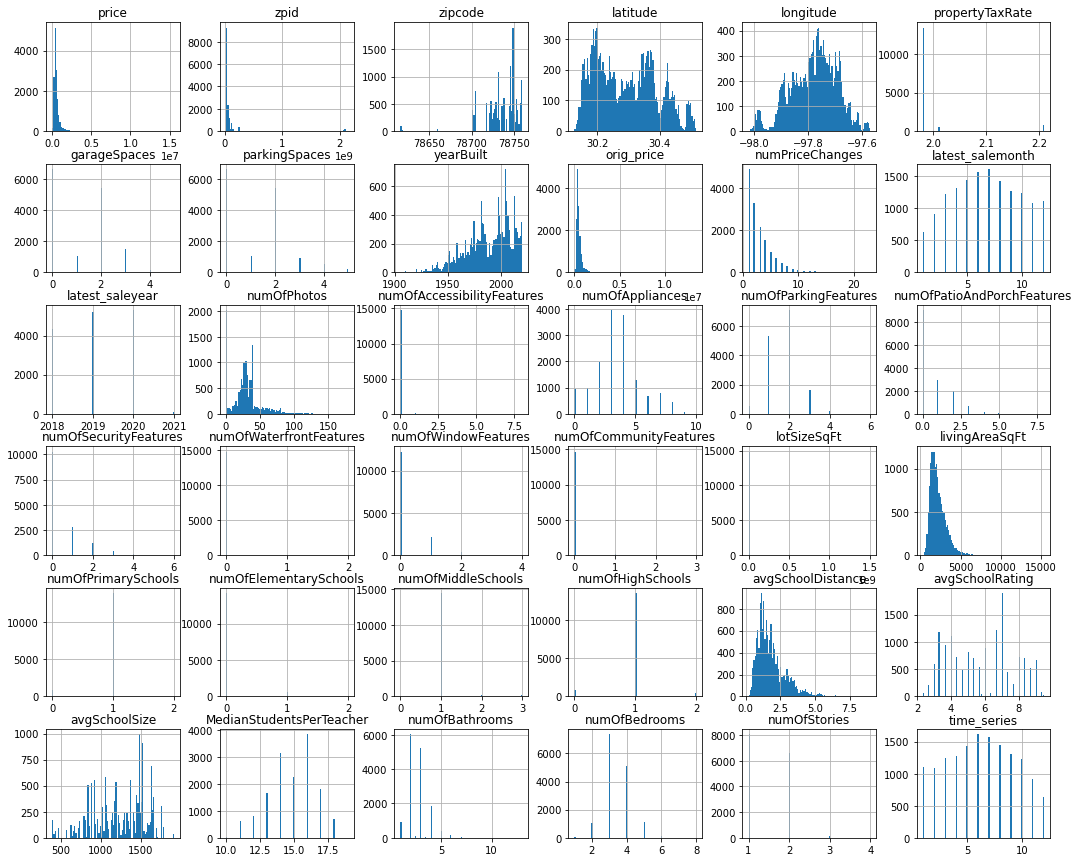

In [41]:

df.hist(figsize=(18,15), bins=100);

In [42]:
def iqr_outliers(column):
    """return the lower range and upper range for the data based on IQR*1.6"""
    Q1,Q3 = np.percentile(column , [25,75])
    iqr = Q3 - Q1
    lower_range = Q1 - (1.6 * iqr)
    upper_range = Q3 + (1.6 * iqr)
    return lower_range,upper_range  

In [43]:
lotlower,lotupper = iqr_outliers(df.lotSizeSqFt)
sqftlower, sqftupper = iqr_outliers(df.livingAreaSqFt)

In [44]:
df.drop(df[ (df.lotSizeSqFt > lotupper) | (df.lotSizeSqFt < lotlower) ].index , inplace=True)
df.drop(df[ (df.livingAreaSqFt > sqftupper) | (df.livingAreaSqFt < sqftlower) ].index , inplace=True)

In [45]:
df.loc[(df['homeType']=='Condo') | (df['homeType']=='Townhouse') & (df['livingAreaSqFt']<1200) & (df['lotSizeSqFt']>8000), 'lotSizeSqFt'] = df['lotSizeSqFt'].median()

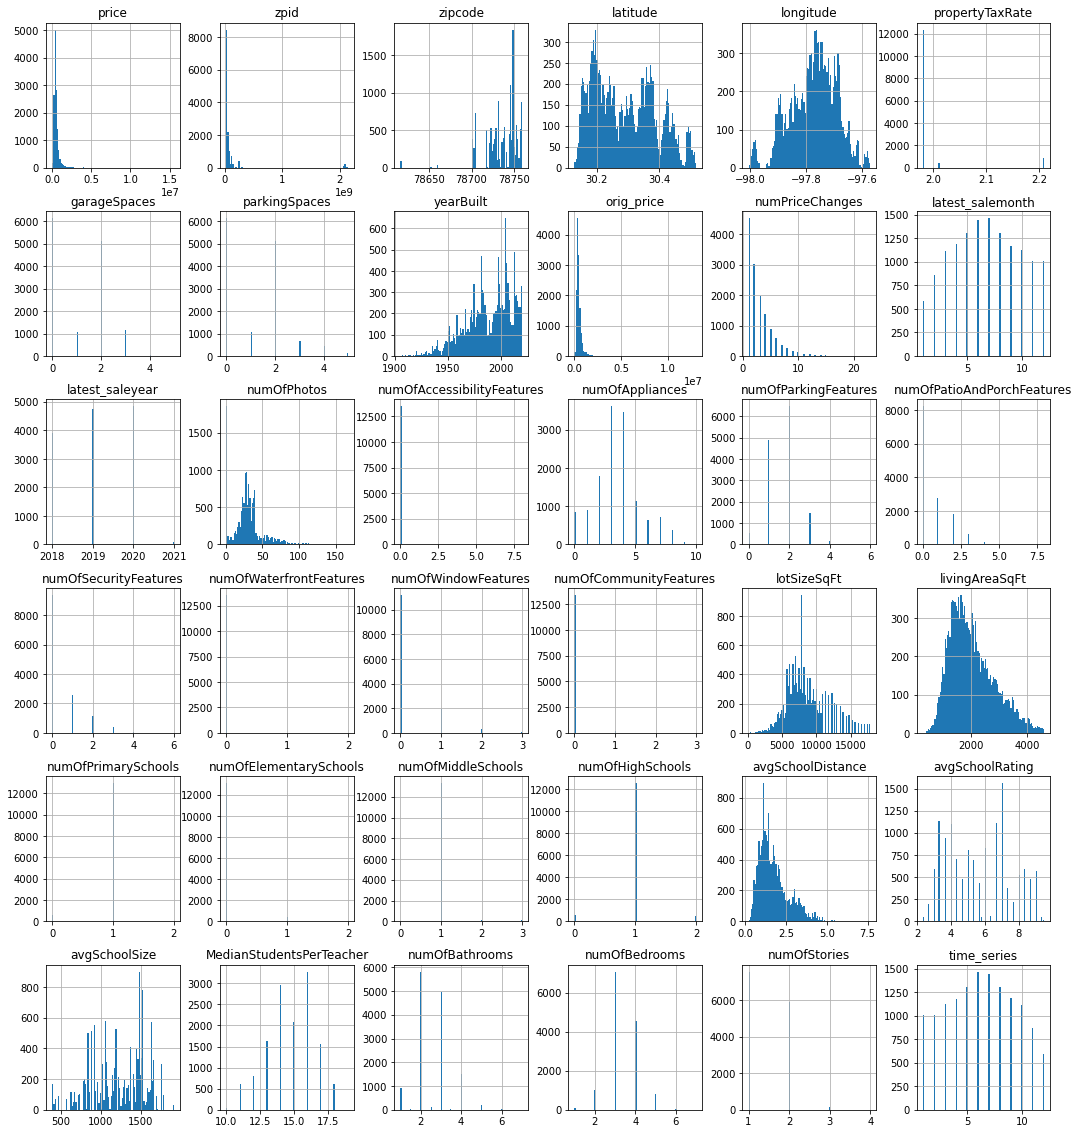

In [46]:
df.hist(figsize=(18,20), bins=100);

In [47]:
# group our dataframe by zipcode on median home price, sorted ascending. 
zipsorted = pd.DataFrame(df.groupby('zipcode')['price'].median().sort_values(ascending=True))

# divide our dataframe into groups with entries per group as specified above,
# and assign this number to a new column
zipsorted['rank'] = np.divmod(np.arange(len(zipsorted)), 1)[0]+1

# function that looks up a segment that a data entry belongs to
def make_group(x, frame, column):
    y = frame.loc[(frame.index == x)][column]
    z = np.array(y)
    z[0]
    return z[0]

# make a new column on our dataframe. Look up each zip entry's group, and append to the column.
df['zip_rank'] = df['zipcode'].apply(lambda x: make_group(x, zipsorted, 'rank'))

# apply the median home price per zip code to the data frame
df['median_zip'] = df['zipcode'].apply(lambda x: round(df.loc[df['zipcode']==x]['price'].median(), 0))

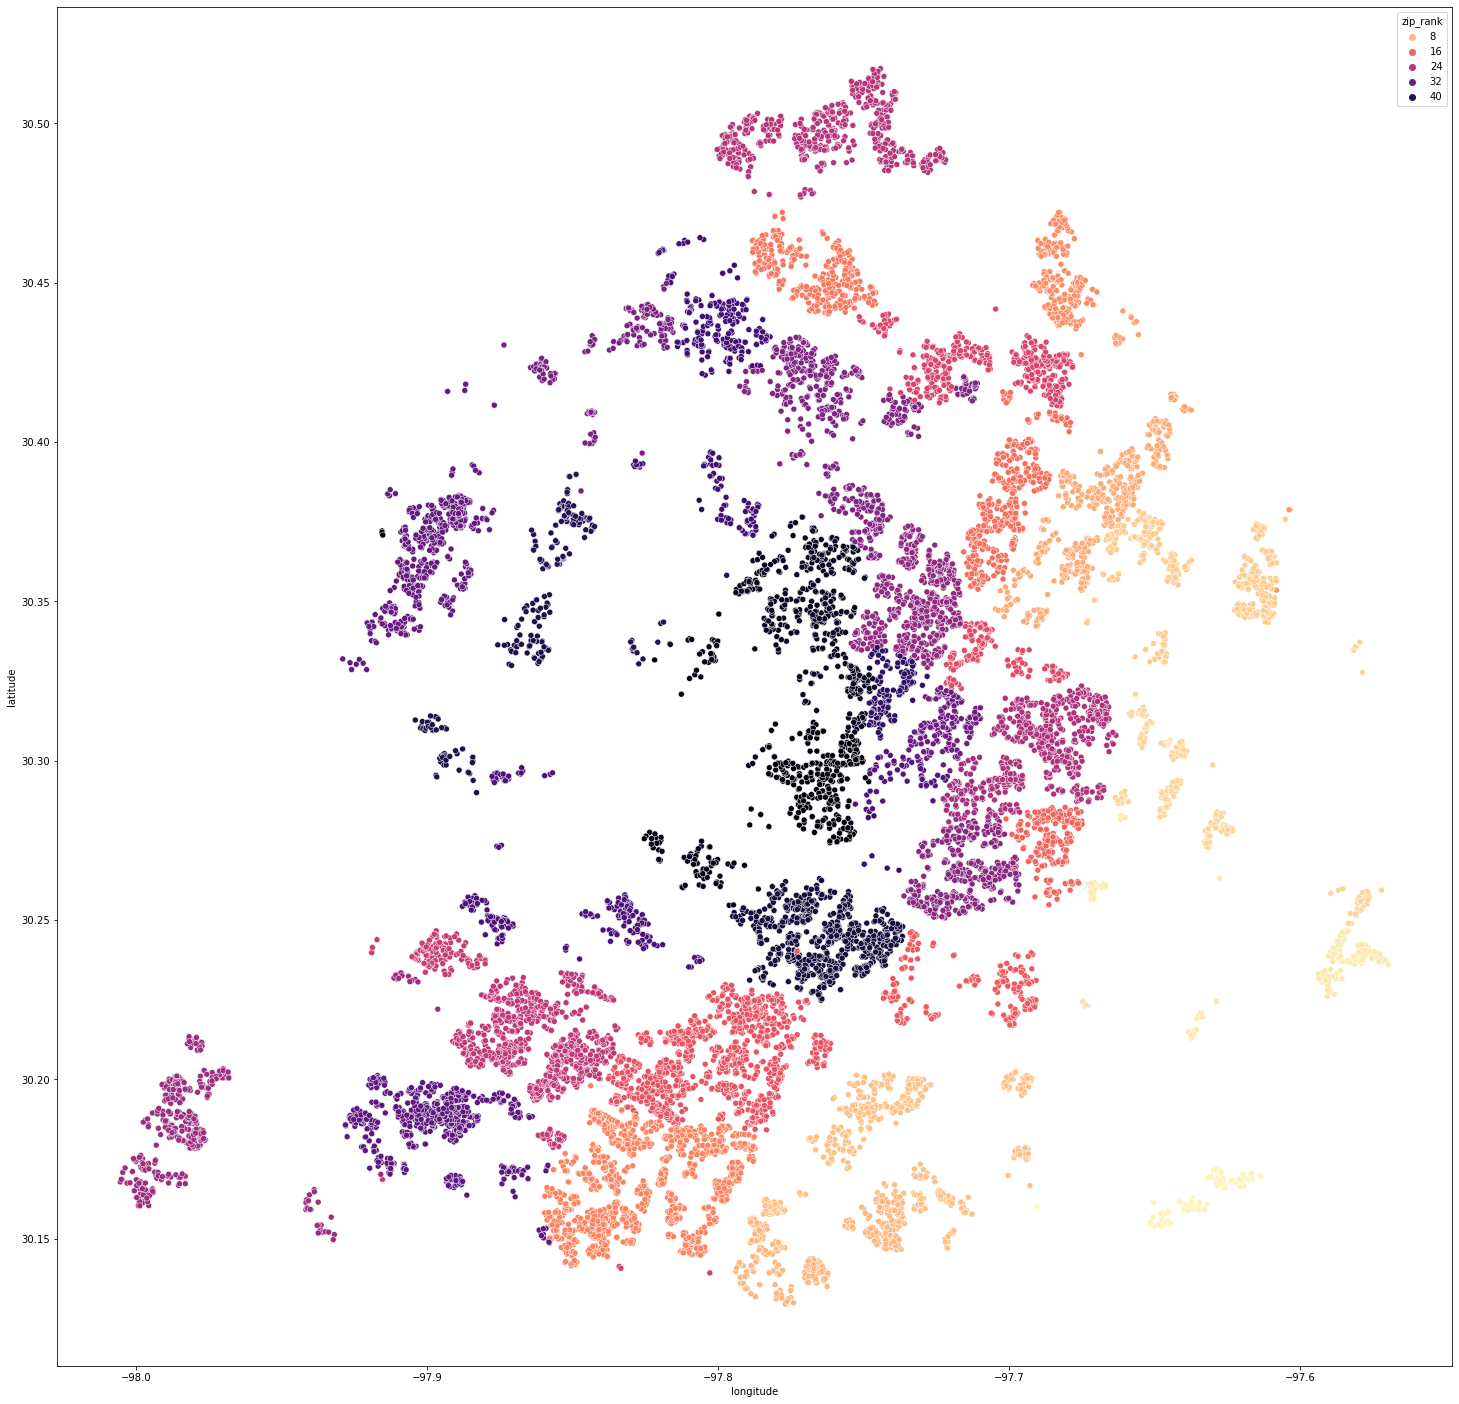

In [49]:
plt.figure(figsize=(25,25))

sns.scatterplot(data=df, x="longitude", y="latitude", hue="zip_rank", palette="magma_r");

In [50]:
df.isna().sum()

price                         0
zpid                          0
city                          0
streetAddress                 0
zipcode                       0
description                   0
latitude                      0
longitude                     0
propertyTaxRate               0
garageSpaces                  0
hasAssociation                0
hasCooling                    0
hasGarage                     0
hasHeating                    0
hasSpa                        0
hasView                       0
homeType                      0
parkingSpaces                 0
yearBuilt                     0
orig_price                    0
numPriceChanges               0
latest_saledate               0
latest_salemonth              0
latest_saleyear               0
latestPriceSource             0
numOfPhotos                   0
numOfAccessibilityFeatures    0
numOfAppliances               0
numOfParkingFeatures          0
numOfPatioAndPorchFeatures    0
numOfSecurityFeatures         0
numOfWat

In [51]:
df.dtypes

price                         float64
zpid                            int64
city                           object
streetAddress                  object
zipcode                         int64
description                    object
latitude                      float64
longitude                     float64
propertyTaxRate               float64
garageSpaces                    int64
hasAssociation                   bool
hasCooling                       bool
hasGarage                        bool
hasHeating                       bool
hasSpa                           bool
hasView                          bool
homeType                       object
parkingSpaces                   int64
yearBuilt                       int64
orig_price                    float64
numPriceChanges                 int64
latest_saledate                object
latest_salemonth                int64
latest_saleyear                 int64
latestPriceSource              object
numOfPhotos                     int64
numOfAccessi

In [52]:
convert_to_bool = ['numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures', 'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures', 'numOfWaterfrontFeatures', 'numOfWindowFeatures', 'numOfCommunityFeatures']

df_convert_to_bool = df[convert_to_bool]
df_convert_to_bool.describe()

,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures
count,13574.000000,13574.000000,13574.000000,13574.000000,13574.000000,13574.000000,13574.000000,13574.000000
mean,0.013408,3.483645,1.701635,0.656991,0.469501,0.001400,0.204877,0.011493
std,0.185601,1.853069,0.778100,0.967342,0.823246,0.039309,0.480615,0.112639
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,4.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,8.000000,10.000000,6.000000,8.000000,6.000000,2.000000,3.000000,3.000000


In [53]:
# set our random seed for the notebook. We could randomize this each time the notebook is run,
# but ultimately we want all of our train/test splits to use the same data
randomstate = 2

y = pd.DataFrame(df['price'])
x = df.drop('price', axis=1,)

# creating our train/validation sets and our test sets
train_data, holdout, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=randomstate)

# reset indices to prevent any index mismatches
train_data.reset_index(inplace=True)
train_data.drop('index', axis=1, inplace=True)

holdout.reset_index(inplace=True)
holdout.drop('index', axis=1, inplace=True)

y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [54]:
def calc_smooth_mean(df, by, on, m, target_df):
    '''input a pandas.DataFrame, a categorical column name, the name of the target column, and a weight .'''
    # Compute the global mean
    mean = df[on].mean() 

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])  
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return round(target_df[by].map(smooth), 0) 

num_of_samples = train_data.shape[0]
zip_samples = num_of_samples/train_data['zipcode'].unique().shape[0]
month_samples = num_of_samples/train_data['latest_salemonth'].unique().shape[0]


In [55]:
# create smooth additive encoded variables for zipcode, year built, and monthsold
train_data['zip_smooth'] = calc_smooth_mean(train_data, 'zipcode', 'price', zip_samples, train_data)
train_data['year_smooth'] = calc_smooth_mean(train_data, 'yearBuilt', 'price', 300, train_data)
train_data['month_smooth'] = calc_smooth_mean(train_data, 'latest_salemonth', 'price', month_samples, train_data)

# Create a wider lat and long zone to calculate an area mean
train_data['lat_zone'] = round(train_data['latitude'], 2)
train_data['long_zone'] = round(train_data['longitude'], 2)

lat_samples = num_of_samples/train_data['lat_zone'].unique().shape[0]
long_samples = num_of_samples/train_data['long_zone'].unique().shape[0]

# calculate smooth mean variables for lat and long, then create an interactive variable describing both together
train_data['lat_smooth'] = calc_smooth_mean(train_data, 'lat_zone', 'price', lat_samples, train_data)
train_data['long_smooth'] = calc_smooth_mean(train_data, 'long_zone', 'price', long_samples, train_data)
train_data['lat_long'] = round(np.sqrt(train_data['lat_smooth']) + np.sqrt(train_data['long_smooth']), 0)

In [56]:
train_data.corr()

,price,zpid,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,parkingSpaces,yearBuilt,orig_price,numPriceChanges,latest_salemonth,latest_saleyear,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,time_series,zip_rank,median_zip,zip_smooth,year_smooth,month_smooth,lat_zone,long_zone,lat_smooth,long_smooth,lat_long
price,1.000000,0.015008,-0.195826,0.066487,-0.153889,-0.056927,0.110590,-0.083709,0.027643,0.071564,0.029046,0.087685,0.092342,0.098365,-0.000031,0.994489,-0.000419,-0.045492,0.073908,0.120355,0.027213,0.042313,0.093401,0.073848,0.054763,0.052347,0.063632,-0.012778,0.259082,0.466542,-0.120999,0.095762,0.052296,-0.174479,-0.069317,0.311989,0.054076,0.230690,0.402533,0.258364,0.194990,0.045492,0.579303,0.620871,0.601358,0.259601,0.049212,0.066459,-0.154038,0.379774,0.338956,0.492372
zpid,0.015008,1.000000,-0.052230,-0.053848,0.014008,-0.011564,0.009268,0.111109,-0.032816,0.026391,-0.060271,0.006280,-0.001861,0.003939,0.222974,0.018102,-0.047001,0.013904,0.049158,-0.014890,0.011188,0.010650,-0.059839,0.025200,0.050631,-0.006453,-0.015904,0.002073,-0.080267,0.000179,-0.004814,0.008550,-0.001501,0.021007,0.051599,-0.044815,-0.037379,-0.072172,0.079378,-0.042873,0.003474,-0.013904,-0.027635,-0.018952,-0.009431,0.369706,-0.010315,-0.053927,0.014221,0.023524,-0.032382,-0.005953
zipcode,-0.195826,-0.052230,1.000000,-0.047792,-0.151420,-0.176535,-0.021862,-0.006148,0.073106,-0.030703,0.045368,-0.013102,-0.059861,-0.013079,-0.012821,-0.198199,-0.052597,-0.003949,-0.013937,-0.012284,-0.013490,0.015146,-0.085735,-0.005554,0.006950,0.006215,0.014892,0.002070,0.090170,-0.031902,-0.064485,0.072945,-0.011447,0.059366,0.056868,0.063587,0.136899,0.110465,-0.060786,0.034515,-0.054097,0.003949,-0.240131,-0.287046,-0.421484,-0.196167,0.003589,-0.047765,-0.150799,-0.350690,-0.126129,-0.320784
latitude,0.066487,-0.053848,-0.047792,1.000000,0.351973,0.469540,0.028955,-0.063534,0.035569,0.020535,0.025067,0.052344,0.031106,0.028177,-0.119578,0.066321,0.018633,0.000454,-0.039561,0.044635,-0.017786,-0.002624,0.160620,-0.012973,-0.026953,0.015672,0.014225,0.004555,0.151719,0.120842,-0.066135,0.115503,-0.019399,0.138328,-0.034164,0.268240,0.060282,-0.014293,0.043969,0.084050,0.031692,-0.000454,0.167103,0.129083,0.134365,-0.104564,-0.004414,0.999577,0.352295,0.235809,0.056335,0.210161
longitude,-0.153889,0.014008,-0.151420,0.351973,1.000000,-0.019933,-0.090291,-0.275389,-0.064074,-0.023001,-0.047821,-0.045778,-0.101440,-0.085470,-0.224423,-0.155535,-0.032477,-0.008842,-0.022977,-0.087195,0.015993,-0.011519,-0.001765,-0.080018,-0.093106,-0.009081,-0.127382,-0.062204,-0.271699,-0.446594,0.117001,-0.010052,-0.186221,0.460889,-0.194468,-0.547024,-0.351265,-0.604275,-0.319699,-0.284737,-0.155396,0.008842,-0.386746,-0.285784,-0.155023,0.066137,-0.001810,0.352309,0.999400,0.296132,-0.271728,0.015463
propertyTaxRate,-0.056927,-0.011564,-0.176535,0.469540,-0.019933,1.000000,0.036316,0.131888,0.033382,0.010966,0.019355,0.030114,0.056627,0.033592,0.124703,-0.057556,-0.020325,0.006493,-0.035030,0.034571,-0.017134,0.007565,0.282496,-0.000977,0.011263,0.001044,0.012648,0.040984,0.026328,0.154534,0.027825,-0.045185,-0.016955,-0.043507,-0.008412,0.205852,0.174194,-0.012392,0.111067,0.128078,0.069622,-0.006493,-0.046633,-0.072769,-0.065544,-0.055698,-0.002875,0.469048,-0.019384,-0.104901,0.273926,0.114659
garageSpaces,0.110590,0.009268,-0.021862,0.028955,-0.090291,0.036316,1.000000,0.049587,0.049511,0.919366,0.045537,0.208374,0.195950,0.981088,0.089528,0.129298,0.113414,0.101424,0.357815,0.291911,0.068539,0.170240,0.698486,0.257865,0.189827,0.

In [60]:
df_correlations = train_data.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns in a new column named "pairs"
df_correlations['pairs'] = list(zip(df_correlations.level_0, df_correlations.level_1))

# set index to pairs
df_correlations.set_index(['pairs'], inplace = True)

# rename our results column to correlation
df_correlations.rename(columns={0: "correlation"}, inplace=True)

# Drop 1:1 correlations to get rid of self pairs
df_correlations.drop(df_correlations[df_correlations['correlation'] == 1.000000].index, inplace=True)

# view pairs above 75% correlation and below 90% correlation (engineered features will correlate with each other above 95%)
df_correlations[(df_correlations.correlation>.75) & (df_correlations.correlation<.95)]

,level_0,level_1,correlation
pairs,,,
"(zip_smooth, median_zip)",zip_smooth,median_zip,0.945171
"(median_zip, zip_smooth)",median_zip,zip_smooth,0.945171
"(garageSpaces, hasGarage)",garageSpaces,hasGarage,0.919366
"(hasGarage, garageSpaces)",hasGarage,garageSpaces,0.919366
"(zip_rank, zip_smooth)",zip_rank,zip_smooth,0.903106
"(zip_smooth, zip_rank)",zip_smooth,zip_rank,0.903106
"(latest_salemonth, month_smooth)",latest_salemonth,month_smooth,0.894119
"(month_smooth, latest_salemonth)",month_smooth,latest_salemonth,0.894119
"(time_series, month_smooth)",time_series,month_smooth,0.894119


In [57]:
df_correlations = train_data.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_correlations.loc[df_correlations['level_0'] == 'price'].sort_values(0, ascending=False)

,level_0,level_1,0
0,price,price,1.000000
15,price,orig_price,0.994489
43,price,median_zip,0.620871
44,price,zip_smooth,0.601358
42,price,zip_rank,0.579303
51,price,lat_long,0.492372
29,price,livingAreaSqFt,0.466542
38,price,numOfBathrooms,0.402533
49,price,lat_smooth,0.379774
50,price,long_smooth,0.338956


In [62]:
# combine all school counts into a single field
train_data['numOfSchools'] = train_data['numOfPrimarySchools'] + train_data['numOfElementarySchools'] + train_data['numOfMiddleSchools'] + train_data['numOfHighSchools']
holdout['numOfSchools'] = holdout['numOfPrimarySchools']  + holdout['numOfElementarySchools'] + holdout['numOfMiddleSchools'] + holdout['numOfHighSchools']

In [61]:
categories = ['zipcode', 'yearBuilt', 'hasAssociation', 'hasCooling', 'hasHeating', 'hasSpa', 'hasView', 'accessibility', 'patioporch', 'security',
          'waterfront', 'windowfeatures', 'community', 'latest_salemonth', 'numOfSchools', 'garageSpaces', 'propertyTaxRate', ]

df_categoricals = train_data[categories]

df_categoricals['price'] = train_data['price']


KeyError: "['security', 'waterfront', 'patioporch', 'accessibility', 'windowfeatures', 'community', 'numOfSchools'] not in index"